# NLP with H2O Tutorial
The focus of this tutorial is to provide an introduction to H2O's Word2Vec algorithm. Word2Vec is an algorithm that trains a shallow neural network model to learn vector representations of words. These vector representations are able to capture the meanings of words. During the tutorial, we will use H2O's Word2Vec implementation to understand relationships between words in our text data. We will use the model results to find similar words and synonyms. We will also use it to showcase how to effectively represent text data for machine learning problems where we will highlight the impact this representation can have on accuracy.

### More information and code examples are available in the Word2Vec Documentation

Supervised Learning with Text Data
For the demo, we use a subset of the Amazon Reviews dataset. The goal here is to predict whether or not an Amazon review is positive or negative.

The tutorial is split up into three parts. In the first part, we will train a model using non-text predictor variables. In the second and third part, we will train a model using our text columns. The text columns in this dataset are the review of the product and the summary of the review. In order to leverage our text columns, we will train a Word2Vec model to convert text into numeric vectors.

# Initial Model - No Text
In this section, you will see how accurate your model is if you do not use any text columns. You will:

Specify a training frame.
Specify a test frame.
Train a GBM model on non-text predictor variables such as: ProductId, UserId, Time, etc.
Analyze our initial model - AUC, confusion matrix, variable importance, partial dependency plots

## Predicting Good Amazon Reviews

Orginal Source - https://docs.h2o.ai/h2o-tutorials/latest-stable/h2o-world-2017/nlp/index.html 

For this demo, we will be using the [Amazon Fine Food Reviews Data](https://www.kaggle.com/snap/amazon-fine-food-reviews).  The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.

This script is based off of the [Craigslist Word2Vec Demo](https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb).

## Import Data

We will begin by importing our review data into our H2O cluster.  In this case, I will be starting up an H2O cluster on my local computer.

In [1]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.0 MB 36 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.2-py2.py3-none-any.whl size=177070945 sha256=b68f53cfa86e238ecca747afbf204d01092eab7ea91976f5a1a72a553f62b84a
  Stored in directory: /root/.cache/pip/wheels/a5/2b/ae/534595df09001e1573b1046be62a3f049507307340119db65c
Successfully built h2o


In [2]:
import h2o

In [3]:
h2o.init(max_mem_size="4G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1b1qbo7b
  JVM stdout: /tmp/tmp1b1qbo7b/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1b1qbo7b/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_1mqg7a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [4]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/nlp/AmazonReviews.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"


# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
#' Add Target Column: "PositiveReview"
reviews["PositiveReview"] = (reviews["Score"] >= 4).ifelse("1", "0")

In [6]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.<br />I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)<br /><br />They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.<br /><br />The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.<br /><br />If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strip

In [7]:
reviews["PositiveReview"].table()

PositiveReview,Count
0,21791
1,78209


## Train Baseline Model

We will start by training a baseline model that does not use the review and instead uses other attributes in our dataset.

In [8]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

reviews["Train"][0]

Train
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes


In [9]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [10]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )
gbm_baseline.train(
                   x = predictors, y = response, 
                   training_frame = train, validation_frame = test
                  )

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,26567.0,5.0,5.0,5.0,20.0,32.0,30.68




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.130956777742102
RMSE: 0.3618795072149043
LogLoss: 0.42253080807967447
Mean Per-Class Error: 0.36712655471537
AUC: 0.7734035476280761
AUCPR: 0.9108898279706498
Gini: 0.5468070952561521

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5263971406120592: 


,,0,1,Error,Rate
0,0,4988.0,12143.0,0.7088,(12143.0/17131.0)
1,1,1598.0,61263.0,0.0254,(1598.0/62861.0)
2,Total,6586.0,73406.0,0.1718,(13741.0/79992.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.526397,0.899161,257.0
1,max f2,0.268703,0.951074,341.0
2,max f0point5,0.736669,0.873236,166.0
3,max accuracy,0.586273,0.829558,232.0
4,max precision,0.952026,1.000000,0.0
5,max recall,0.067206,1.000000,396.0
6,max specificity,0.952026,1.000000,0.0
7,max absolute_mcc,0.628674,0.418242,213.0
8,max min_per_class_accuracy,0.824437,0.697571,108.0
9,max mean_per_class_accuracy,0.800070,0.708231,129.0



Gains/Lift Table: Avg response rate: 78.58 %, avg score: 78.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010014,0.925071,1.255047,1.255047,0.986267,0.933300,0.986267,0.933300,0.012567,0.012567,25.504658,25.504658,0.011925
1,2,0.020015,0.918354,1.239118,1.247087,0.973750,0.921189,0.980012,0.927248,0.012392,0.024960,23.911821,24.708737,0.023092
2,3,0.030041,0.914395,1.236028,1.243396,0.971322,0.916349,0.977112,0.923611,0.012392,0.037352,23.602814,24.339636,0.034142
3,4,0.040017,0.911995,1.200763,1.232768,0.943609,0.913211,0.968760,0.921018,0.011979,0.049331,20.076316,23.276803,0.043494
4,5,0.050018,0.910264,1.210486,1.228313,0.951250,0.911105,0.965259,0.919036,0.012106,0.061437,21.048647,22.831283,0.053323
5,6,0.100135,0.903173,1.192850,1.210564,0.937391,0.906373,0.951311,0.912698,0.059783,0.121220,19.285042,21.056392,0.098454
6,7,0.150015,0.897408,1.168551,1.196595,0.918296,0.900175,0.940333,0.908534,0.058287,0.179507,16.855145,19.659477,0.137712
7,8,0.200008,0.889871,1.168467,1.189564,0.918230,0.894409,0.934808,0.905004,0.058415,0.237922,16.846723,18.956421,0.177038
8,9,0.300055,0.874648,1.154381,1.177833,0.907160,0.880898,0.925590,0.896966,0.115493,0.353415,15.438074,17.783297,0.249159
9,10,0.400003,0.857089,1.123703,1.164308,0.883052,0.867407,0.914961,0.889580,0.112311,0.465726,12.370290,16.430764,0.306891




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.16702675167057843
RMSE: 0.40868906477978884
LogLoss: 0.5166125543011001
Mean Per-Class Error: 0.46296820768192243
AUC: 0.6161676151902472
AUCPR: 0.8139632348448335
Gini: 0.23233523038049442

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,,0,1,Error,Rate
0,0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,1,128.0,15220.0,0.0083,(128.0/15348.0)
2,Total,512.0,19496.0,0.2201,(4404.0/20008.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.459316,0.873608,292.0
1,max f2,0.268408,0.942886,347.0
2,max f0point5,0.765918,0.830179,162.0
3,max accuracy,0.632496,0.784036,221.0
4,max precision,0.902818,1.000000,0.0
5,max recall,0.059845,1.000000,399.0
6,max specificity,0.902818,1.000000,0.0
7,max absolute_mcc,0.750033,0.270509,171.0
8,max min_per_class_accuracy,0.834891,0.569313,82.0
9,max mean_per_class_accuracy,0.790503,0.602336,144.0



Gains/Lift Table: Avg response rate: 76.71 %, avg score: 80.92 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010046,0.882908,1.134995,1.134995,0.870647,0.889106,0.870647,0.889106,0.011402,0.011402,13.499482,13.499482,0.005823
1,2,0.020092,0.875996,1.024738,1.079867,0.786070,0.878952,0.828358,0.884029,0.010295,0.021697,2.473818,7.986650,0.006890
2,3,0.044582,0.873617,1.048219,1.062482,0.804082,0.873984,0.815022,0.878511,0.025671,0.047368,4.821901,6.248167,0.011960
3,4,0.053079,0.871717,0.981551,1.049527,0.752941,0.872084,0.805085,0.877482,0.008340,0.055708,-1.844885,4.952669,0.011287
4,5,0.110056,0.867069,1.058907,1.054383,0.812281,0.869057,0.808810,0.873120,0.060334,0.116041,5.890750,5.438324,0.025698
5,6,0.154338,0.863193,1.077034,1.060882,0.826185,0.864890,0.813795,0.870759,0.047694,0.163735,7.703359,6.088201,0.040344
6,7,0.206767,0.858838,1.065019,1.061931,0.816969,0.861009,0.814600,0.868287,0.055838,0.219573,6.501867,6.193092,0.054980
7,8,0.300130,0.855122,1.074721,1.065910,0.824411,0.856942,0.817652,0.864758,0.100339,0.319911,7.472101,6.590959,0.084933
8,9,0.405338,0.849397,1.060238,1.064438,0.813302,0.851804,0.816523,0.861395,0.111545,0.431457,6.023845,6.443761,0.112144
9,10,0.500000,0.837672,1.057215,1.063070,0.810982,0.844024,0.815474,0.858107,0.100078,0.531535,5.721454,6.307011,0.135398




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-07 09:01:24,0.066 sec,0.0,0.410238,0.519415,0.500000,0.785841,1.000000,0.214159,0.423099,0.543788,0.500000,0.767093,1.000000,0.232907
1,,2022-06-07 09:01:27,2.805 sec,10.0,0.378922,0.456027,0.738110,0.892785,1.229748,0.182081,0.411394,0.519999,0.602428,0.806377,1.050615,0.222111
2,,2022-06-07 09:01:28,4.048 sec,20.0,0.370371,0.439853,0.747504,0.897598,1.229859,0.177768,0.409348,0.517033,0.610503,0.809318,1.038944,0.220662
3,,2022-06-07 09:01:30,5.173 sec,30.0,0.366882,0.433010,0.754439,0.901190,1.239733,0.175930,0.408871,0.516586,0.611240,0.812058,1.142902,0.220412
4,,2022-06-07 09:01:31,6.106 sec,40.0,0.364583,0.428173,0.762339,0.905534,1.250308,0.174067,0.408982,0.517169,0.613924,0.812089,1.070138,0.220312
5,,2022-06-07 09:01:31,6.844 sec,50.0,0.361880,0.422531,0.773404,0.910890,1.255047,0.171780,0.408689,0.516613,0.616168,0.813963,1.134995,0.220112



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,HelpfulnessNumerator,6629.697754,1.000000,0.430967
1,HelpfulnessDenominator,5733.745117,0.864858,0.372725
2,Time,1460.428345,0.220286,0.094936
3,ProductId,1310.930908,0.197736,0.085218
4,UserId,248.504898,0.037484,0.016154


In [11]:
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on Validation Data: 0.616


We can see that there is a big room for improvement.  Our error is 22%.  To improve our model, we will train word embeddings for the review.

In [12]:
gbm_baseline.confusion_matrix(valid = True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,,0,1,Error,Rate
0,0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,1,128.0,15220.0,0.0083,(128.0/15348.0)
2,Total,512.0,19496.0,0.2201,(4404.0/20008.0)


The variable importance plot below shows us that the most important variable is `HelpfulnessNumerator`.  Looking at the partial dependency plot for that variable, we see that the more people who find the review helpful, the more likely it is a good review.

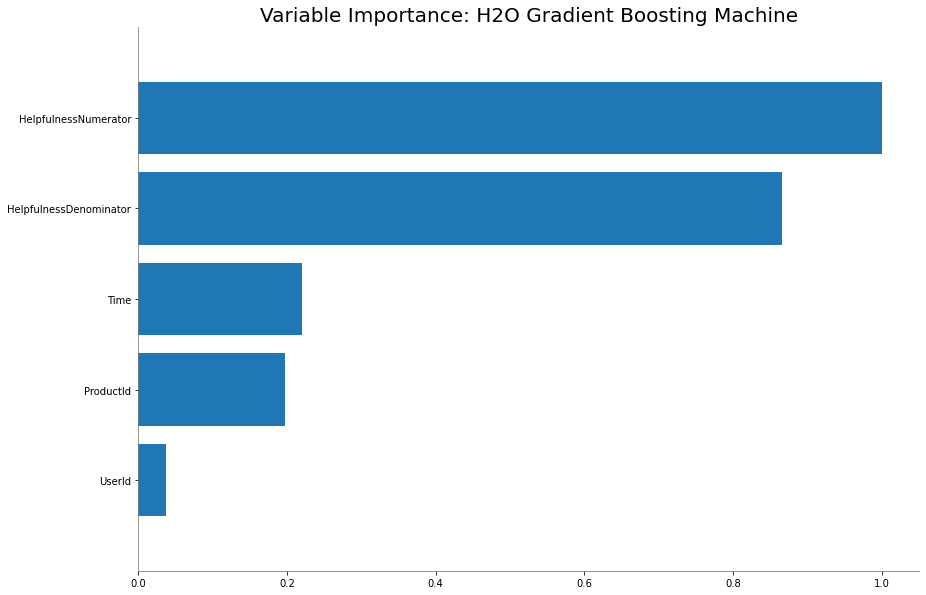

<Figure size 432x288 with 0 Axes>

In [13]:
gbm_baseline.varimp_plot()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


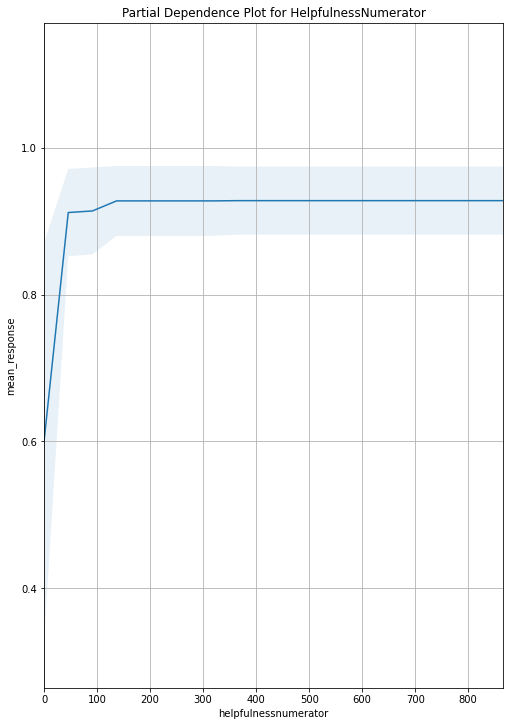

In [14]:
%matplotlib inline  
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

## Tokenize Words in Review

Our first step will be to tokenize the words in the review column. We will do this by creating a function called `tokenize`.  This will split the reviews into words and remove any stop words, small words, or words with numbers in them.

In [15]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package
import pandas as pd
import os

# Use local data file or download from GitHub
docker_data_path = "/home/h2o/data/nlp/stopwords.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/h2o-world-2017/nlp/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [16]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [21]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [22]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## Train Word2Vec Model

Now that we've tokenized our words, we can train a word2vec model.  We can use the `find_synonms` function to sanity check our word2vec model after training.

In [33]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

# This takes time to run - left commented out
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

# Pre-trained model available on s3: https://s3.amazonaws.com/tomk/h2o-world/megan/w2v.hex
#w2v_model = h2o.load_model("/home/h2o/data/megan/w2v.hex")
#w2v_model = h2o.load_model('https://s3.amazonaws.com/tomk/h2o-world/megan/w2v.hex')

word2vec Model Build progress: |█████████████████████████████████████████████████| (done) 100%


H2OResponseError: ignored

In [34]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.8057905435562134),
             ('coffees', 0.7930382490158081),
             ('espresso', 0.7769548296928406),
             ('expresso', 0.7612943053245544),
             ('brewed', 0.754109263420105)])

In [35]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('moldy', 0.6945568323135376),
             ('rancid', 0.6864337921142578),
             ('expired', 0.6522181034088135),
             ('inedible', 0.6519212126731873),
             ('experation', 0.6267678141593933)])

Now that we have a word embedding for each word in our vocabulary, we will aggregate the words for each review using the `transform` function.  This will give us one aggregated word embedding for each review.

In [36]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

In [37]:
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0499154,0.0942412,-0.0684801,0.0828252,0.110265,-0.0115189,0.134398,-0.0275272,-0.0534171,-0.183551,0.0167671,0.0790481,0.192409,0.105143,0.0480855,0.0526018,-0.116875,0.0441946,-0.0180532,0.0989954,0.105131,0.171948,-0.108895,0.00401244,-0.00568534,0.00386727,0.0696761,0.099051,0.119844,0.115133,-0.0373341,-0.0387664,-0.122544,0.108761,-0.0652304,-0.0313171,0.0179572,0.0917907,0.083415,-0.0370281,0.113382,-0.113062,0.0238758,0.296352,0.0559636,0.0258843,0.0589791,0.0257395,0.0622698,0.0776085,-0.0191692,0.128577,0.241418,-0.0177458,-0.00515056,-0.136095,-0.00260071,-0.0392589,0.0478575,-0.0906529,-0.0257067,-0.010345,0.0255297,0.0410792,-0.166931,-0.0855899,-0.120074,-0.0718261,-0.216169,-0.104583,-0.0035747,0.0474887,0.0249344,-0.0517845,0.0414988,0.0954148,0.0968292,-0.191644,0.205475,-0.166637,0.188176,-0.0156154,0.192117,0.16875,0.117684,-0.0456814,-0.104454,0.137164,0.0384886,0.0972748,-0.0433051,0.12689,-0.0827864,-0.0199085,-0.0973158,-0.0629424,0.00574473,0.0917212,-0.11446,0.230703
0.166378,0.099525,0.00196513,0.076429,0.14103,-0.128688,-0.00198972,-0.180438,0.0125181,-0.16489,-0.139778,-0.0388977,0.0882222,0.0191146,-0.143219,-0.00465564,0.00690051,-0.0142725,-0.141964,-0.0600444,-0.0355551,0.0509483,0.074328,-0.000365869,0.237964,0.0973674,0.192585,0.156974,-0.122242,-0.0113875,-0.0784875,0.137282,-0.135921,0.00673183,0.0343791,0.018315,-0.0173633,0.0729901,-0.136633,-0.109673,-0.121863,-0.0344166,-0.0898444,0.217656,0.0501252,0.086568,0.0665466,0.112872,0.128083,0.0156326,0.14543,-0.0253615,0.116019,0.0583487,-0.119603,-0.0341964,-0.0473815,-0.132531,-0.0103235,0.0269642,-0.0931135,0.0754205,-0.0119235,0.0791601,-0.153886,-0.0218532,-0.00801481,0.155183,-0.131224,0.00488165,0.0568006,-0.0154212,-0.0536831,-0.00606321,0.0469114,0.178515,0.0887158,0.0222026,0.21168,-0.110891,0.0372101,-0.236037,0.0164879,0.022622,-0.00156501,0.0761212,-0.127829,0.0517878,0.0124466,-0.201918,0.0251265,0.0195025,0.0442411,-0.00763133,-0.0478588,-0.0905478,-0.08839,0.10606,0.0607338,0.190519
0.0574571,0.0858501,0.0743926,0.0436537,0.0952849,-0.131049,0.211817,-0.1079,-0.0241251,-0.231987,-0.129956,0.10517,0.069138,0.143387,-0.0154204,0.0514962,-0.159076,0.060584,0.000568659,0.0693966,-0.00401168,0.146434,-0.0584996,0.0119217,0.083161,-0.10286,0.0628287,0.0832133,0.024112,0.0957371,0.0543225,0.0666906,-0.13929,0.0629633,0.0467811,0.135742,0.0779675,0.0123838,-0.0139403,-0.0644646,0.012759,0.0475439,0.00873936,0.301952,0.108807,0.0120813,-0.0899662,0.0635798,0.175318,0.0450173,0.081558,0.0299146,0.289272,0.0189465,-0.0298484,-0.0249029,-0.137853,0.0536411,0.131427,-0.0760373,-0.103434,-0.0199637,-0.022145,0.0713506,-0.0787693,-0.0181439,-0.0949962,0.112091,-0.0695627,0.057794,0.0402587,0.0941527,-0.0386747,0.0856625,-0.0131163,0.0861245,0.00663942,-0.100233,0.137448,0.0360155,0.0958403,-0.0378272,0.0519125,0.109733,-0.0368396,-0.101917,-0.129911,0.113949,0.102864,0.0714012,0.0680851,-0.0543761,0.0363171,-0.0564197,-0.0830488,-0.100103,-0.147966,-0.00200319,0.0193911,0.0510398
0.0448834,0.00243055,-0.0120691,0.10861,0.233114,-0.0768871,0.138413,-0.11438,-0.0197675,-0.180089,-0.152867,0.0865861,0.0070695,0.0621924,0.0610318,0.0492147,-0.0468609,-0.0529836,-0.0631963,0.066766,-0.0279522,0.0693072,-0.075094,-0.0416214,0.077308,-0.0126883,0.0240936,0.0969183,-0.147964,0.116333,-0.0167751,0.0831669,-0.0879228,0.112402,0.0638769,0.0404937,0.0502793,-0.00118423,0.0128725,-0.0802077,-0.12677,0.0714728,-0.12169,0.22409,0.128811,0.0396443,0.0159909,-0.08441,0.00618652,0.105125,0.156989,0.0495124,0.229709,0.0158351,0.101802,-0.111359,-0.114485,-0.0675927,0.133502

In [38]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

## Train GBM Model to Predict Good Review

We will train a GBM model with the same parameters as our baseline gbm.  This time, however, we will add the aggregated word embeddings as predictors. 

In [39]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [40]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_embeddings.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22902.0,5.0,5.0,5.0,29.0,32.0,31.78




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09229718845930604
RMSE: 0.30380452343456976
LogLoss: 0.3065265896087848
Mean Per-Class Error: 0.22983630787669135
AUC: 0.9168321082894816
AUCPR: 0.9739199235146794
Gini: 0.8336642165789632

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.556298604334498: 


,,0,1,Error,Rate
0,0,9960.0,7171.0,0.4186,(7171.0/17131.0)
1,1,2582.0,60279.0,0.0411,(2582.0/62861.0)
2,Total,12542.0,67450.0,0.1219,(9753.0/79992.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.556299,0.925156,241.0
1,max f2,0.355159,0.957594,311.0
2,max f0point5,0.747082,0.925266,161.0
3,max accuracy,0.580744,0.878713,232.0
4,max precision,0.985622,1.000000,0.0
5,max recall,0.044351,1.000000,397.0
6,max specificity,0.985622,1.000000,0.0
7,max absolute_mcc,0.655337,0.625882,202.0
8,max min_per_class_accuracy,0.772002,0.834667,150.0
9,max mean_per_class_accuracy,0.763257,0.836286,154.0



Gains/Lift Table: Avg response rate: 78.58 %, avg score: 78.55 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,0.979514,1.272522,1.272522,1.000000,0.981872,1.000000,0.981872,0.012726,0.012726,27.252191,27.252191,0.012726
1,2,0.020002,0.976924,1.272522,1.272522,1.000000,0.978153,1.000000,0.980012,0.012726,0.025453,27.252191,27.252191,0.025453
2,3,0.030003,0.974839,1.270931,1.271992,0.998750,0.975882,0.999583,0.978635,0.012711,0.038164,27.093126,27.199170,0.038105
3,4,0.040004,0.972954,1.267750,1.270931,0.996250,0.973902,0.998750,0.977452,0.012679,0.050842,26.774996,27.093126,0.050609
4,5,0.050005,0.971261,1.269341,1.270613,0.997500,0.972101,0.998500,0.976382,0.012695,0.063537,26.934061,27.061313,0.063187
5,6,0.100010,0.964055,1.268704,1.269659,0.997000,0.967559,0.997750,0.971970,0.063442,0.126979,26.870435,26.965874,0.125928
6,7,0.150003,0.956944,1.268067,1.269128,0.996499,0.960480,0.997333,0.968141,0.063394,0.190372,26.806697,26.912824,0.188504
7,8,0.200008,0.949903,1.262978,1.267591,0.992500,0.953485,0.996125,0.964477,0.063155,0.253528,26.297800,26.759058,0.249908
8,9,0.300005,0.933475,1.252318,1.262500,0.984123,0.942015,0.992124,0.956990,0.125229,0.378756,25.231810,26.249997,0.367724
9,10,0.400003,0.911483,1.236569,1.256017,0.971746,0.922984,0.987030,0.948489,0.123654,0.502410,23.656868,25.601735,0.478185




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.11659570788268482
RMSE: 0.3414611367091207
LogLoss: 0.3687005731744991
Mean Per-Class Error: 0.3091845157999645
AUC: 0.875226015384426
AUCPR: 0.9553548181828561
Gini: 0.750452030768852

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5210592131748804: 


,,0,1,Error,Rate
0,0,1946.0,2714.0,0.5824,(2714.0/4660.0)
1,1,552.0,14796.0,0.036,(552.0/15348.0)
2,Total,2498.0,17510.0,0.1632,(3266.0/20008.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.521059,0.900603,262.0
1,max f2,0.295242,0.947527,340.0
2,max f0point5,0.786640,0.897389,149.0
3,max accuracy,0.589141,0.839564,236.0
4,max precision,0.986432,1.000000,0.0
5,max recall,0.145650,1.000000,380.0
6,max specificity,0.986432,1.000000,0.0
7,max absolute_mcc,0.698884,0.535289,193.0
8,max min_per_class_accuracy,0.796822,0.794635,144.0
9,max mean_per_class_accuracy,0.820223,0.796343,131.0



Gains/Lift Table: Avg response rate: 76.71 %, avg score: 79.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010046,0.979495,1.297137,1.297137,0.995025,0.981945,0.995025,0.981945,0.013031,0.013031,29.713694,29.713694,0.012816
1,2,0.020042,0.977047,1.303623,1.300372,1.000000,0.978230,0.997506,0.980092,0.013031,0.026062,30.362262,30.037169,0.025847
2,3,0.030038,0.975008,1.290586,1.297115,0.990000,0.975986,0.995008,0.978726,0.012901,0.038963,29.058640,29.711535,0.038319
3,4,0.040034,0.973227,1.290586,1.295485,0.990000,0.974155,0.993758,0.977584,0.012901,0.051863,29.058640,29.548515,0.050790
4,5,0.050030,0.971602,1.303623,1.297111,1.000000,0.972394,0.995005,0.976547,0.013031,0.064894,30.362262,29.711102,0.063821
5,6,0.100010,0.964344,1.290586,1.293850,0.990000,0.967892,0.992504,0.972222,0.064504,0.129398,29.058640,29.385034,0.126179
6,7,0.150040,0.957280,1.289297,1.292332,0.989011,0.960834,0.991339,0.968425,0.064504,0.193901,28.929710,29.233209,0.188322
7,8,0.200020,0.950163,1.272336,1.287335,0.976000,0.953726,0.987506,0.964752,0.063591,0.257493,27.233568,28.733548,0.246763
8,9,0.300030,0.933471,1.264533,1.279735,0.970015,0.942110,0.981676,0.957204,0.126466,0.383959,26.453349,27.973482,0.360354
9,10,0.399990,0.911338,1.228664,1.266972,0.942500,0.922697,0.971886,0.948581,0.122817,0.506776,22.866432,26.697198,0.458493




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-07 09:52:27,0.082 sec,0.0,0.410238,0.519415,0.500000,0.785841,1.000000,0.214159,0.423099,0.543788,0.500000,0.767093,1.000000,0.232907
1,,2022-06-07 09:52:33,6.292 sec,10.0,0.357840,0.410369,0.858028,0.952388,1.269356,0.156341,0.379742,0.448187,0.827996,0.935923,1.303623,0.184826
2,,2022-06-07 09:52:37,10.423 sec,20.0,0.335380,0.366941,0.881953,0.961411,1.270931,0.143852,0.362712,0.412498,0.849470,0.945480,1.303623,0.177479
3,,2022-06-07 09:52:42,14.726 sec,30.0,0.320719,0.338701,0.898790,0.967640,1.272522,0.134238,0.352934,0.392027,0.861759,0.950383,1.303623,0.170882
4,,2022-06-07 09:52:46,18.587 sec,40.0,0.311436,0.320906,0.908764,0.971124,1.272522,0.127163,0.346240,0.378325,0.869938,0.953378,1.303623,0.163335
5,,2022-06-07 09:52:49,22.455 sec,50.0,0.303805,0.306527,0.916832,0.973920,1.272522,0.121925,0.341461,0.368701,0.875226,0.955355,1.297137,0.163235



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C64,6212.911133,1.000000,0.205825
1,C12,2996.340820,0.482276,0.099265
2,HelpfulnessDenominator,2552.117920,0.410777,0.084548
3,C1,2239.645264,0.360482,0.074196
4,C80,1964.926880,0.316265,0.065095
5,HelpfulnessNumerator,1952.153076,0.314209,0.064672
6,C11,1262.692383,0.203237,0.041831
7,C77,927.513428,0.149288,0.030727
8,C57,709.202454,0.114150,0.023495
9,C87,705.277588,0.113518,0.023365



See the whole table with table.as_data_frame()


In [43]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))

Baseline AUC: 0.616
With Embeddings AUC: 0.875


In [44]:
gbm_embeddings.confusion_matrix(valid = True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5210592131748804: 


,,0,1,Error,Rate
0,0,1946.0,2714.0,0.5824,(2714.0/4660.0)
1,1,552.0,14796.0,0.036,(552.0/15348.0)
2,Total,2498.0,17510.0,0.1632,(3266.0/20008.0)


## Adding Summary

We saw that the review column is not the only column with text.  We also have a column called `Summary` which summarizes the review.  We will add the word embeddings of the summary to see if this improves our model.

In [45]:
# Break summaries into sequence of words
summary_words = tokenize(reviews["Summary"].ascharacter())

In [46]:
# Add aggregated summary word embeddings
summary_vecs = w2v_model.transform(summary_words, aggregate_method = "AVERAGE")
summary_vecs.names = ["summary_" + s for s in summary_vecs.names]

ext_reviews = ext_reviews.cbind(summary_vecs)

In [47]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [48]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex"
                                             )
gbm_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_plus_summary.hex


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22795.0,5.0,5.0,5.0,29.0,32.0,31.62




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07915398917181239
RMSE: 0.28134318753403714
LogLoss: 0.2688707234080264
Mean Per-Class Error: 0.1872398043900474
AUC: 0.9397194280298499
AUCPR: 0.9814317129289781
Gini: 0.8794388560596997

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5655769163779338: 


,,0,1,Error,Rate
0,0,11402.0,5729.0,0.3344,(5729.0/17131.0)
1,1,2518.0,60343.0,0.0401,(2518.0/62861.0)
2,Total,13920.0,66072.0,0.1031,(8247.0/79992.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.565577,0.936037,230.0
1,max f2,0.356848,0.962517,297.0
2,max f0point5,0.737481,0.938983,162.0
3,max accuracy,0.616442,0.897215,211.0
4,max precision,0.985765,1.000000,0.0
5,max recall,0.065119,1.000000,388.0
6,max specificity,0.985765,1.000000,0.0
7,max absolute_mcc,0.621506,0.686637,209.0
8,max min_per_class_accuracy,0.769817,0.865020,148.0
9,max mean_per_class_accuracy,0.779182,0.865420,144.0



Gains/Lift Table: Avg response rate: 78.58 %, avg score: 78.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,0.982099,1.270931,1.270931,0.998750,0.983919,0.998750,0.983919,0.012711,0.012711,27.093126,27.093126,0.012652
1,2,0.020002,0.980150,1.270931,1.270931,0.998750,0.981048,0.998750,0.982483,0.012711,0.025421,27.093126,27.093126,0.025304
2,3,0.030003,0.978630,1.272522,1.271461,1.000000,0.979378,0.999167,0.981448,0.012726,0.038148,27.252191,27.146148,0.038031
3,4,0.040004,0.977317,1.272522,1.271727,1.000000,0.977984,0.999375,0.980582,0.012726,0.050874,27.252191,27.172659,0.050757
4,5,0.050005,0.976109,1.269341,1.271249,0.997500,0.976726,0.999000,0.979811,0.012695,0.063569,26.934061,27.124939,0.063335
5,6,0.100010,0.970543,1.270931,1.271090,0.998750,0.973221,0.998875,0.976516,0.063553,0.127122,27.093126,27.109033,0.126596
6,7,0.150003,0.965347,1.268067,1.270083,0.996499,0.967944,0.998083,0.973659,0.063394,0.190516,26.806697,27.008271,0.189173
7,8,0.200008,0.959650,1.267750,1.269499,0.996250,0.962504,0.997625,0.970870,0.063394,0.253909,26.774996,26.949948,0.251691
8,9,0.300005,0.946669,1.262500,1.267166,0.992124,0.953463,0.995791,0.965068,0.126247,0.380156,26.249955,26.716627,0.374260
9,10,0.400003,0.928474,1.251841,1.263335,0.983748,0.938025,0.992781,0.958307,0.125181,0.505337,25.184085,26.333503,0.491853




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.09900093576120984
RMSE: 0.31464414146970837
LogLoss: 0.3208576544972911
Mean Per-Class Error: 0.22433183896127717
AUC: 0.9102306531390202
AUCPR: 0.9686627043928423
Gini: 0.8204613062780404

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5862186451402753: 


,,0,1,Error,Rate
0,0,2810.0,1850.0,0.397,(1850.0/4660.0)
1,1,793.0,14555.0,0.0517,(793.0/15348.0)
2,Total,3603.0,16405.0,0.1321,(2643.0/20008.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.586219,0.916764,223.0
1,max f2,0.347712,0.951954,303.0
2,max f0point5,0.770366,0.917853,150.0
3,max accuracy,0.618102,0.868103,212.0
4,max precision,0.986032,1.000000,0.0
5,max recall,0.057537,1.000000,391.0
6,max specificity,0.986032,1.000000,0.0
7,max absolute_mcc,0.686690,0.621263,184.0
8,max min_per_class_accuracy,0.794793,0.831248,138.0
9,max mean_per_class_accuracy,0.808592,0.832660,130.0



Gains/Lift Table: Avg response rate: 76.71 %, avg score: 78.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010046,0.982037,1.303623,1.303623,1.000000,0.983865,1.000000,0.983865,0.013096,0.013096,30.362262,30.362262,0.013096
1,2,0.020042,0.980277,1.303623,1.303623,1.000000,0.981118,1.000000,0.982495,0.013031,0.026127,30.362262,30.362262,0.026127
2,3,0.030038,0.978796,1.303623,1.303623,1.000000,0.979469,1.000000,0.981488,0.013031,0.039158,30.362262,30.362262,0.039158
3,4,0.040034,0.977545,1.303623,1.303623,1.000000,0.978124,1.000000,0.980648,0.013031,0.052189,30.362262,30.362262,0.052189
4,5,0.050030,0.976160,1.297105,1.302320,0.995000,0.976839,0.999001,0.979887,0.012966,0.065155,29.710451,30.232030,0.064940
5,6,0.100010,0.971160,1.297105,1.299714,0.995000,0.973716,0.997001,0.976803,0.064829,0.129984,29.710451,29.971371,0.128697
6,7,0.150040,0.965987,1.291902,1.297109,0.991009,0.968613,0.995003,0.974072,0.064634,0.194618,29.190174,29.710885,0.191399
7,8,0.200020,0.960578,1.290586,1.295479,0.990000,0.963297,0.993753,0.971380,0.064504,0.259122,29.058640,29.547905,0.253757
8,9,0.300030,0.945996,1.282124,1.291027,0.983508,0.953491,0.990338,0.965417,0.128225,0.387347,28.212360,29.102723,0.374901
9,10,0.399990,0.926972,1.251478,1.281144,0.960000,0.937323,0.982756,0.958396,0.125098,0.512445,25.147772,28.114356,0.482831




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-07 09:53:24,0.140 sec,0.0,0.410238,0.519415,0.500000,0.785841,1.000000,0.214159,0.423099,0.543788,0.500000,0.767093,1.000000,0.232907
1,,2022-06-07 09:53:39,14.859 sec,10.0,0.345510,0.388531,0.883793,0.961552,1.268179,0.141202,0.362355,0.416519,0.866452,0.951065,1.303623,0.161585
2,,2022-06-07 09:53:46,22.152 sec,20.0,0.317263,0.335608,0.909771,0.971258,1.272522,0.124325,0.339759,0.371024,0.888928,0.960530,1.303623,0.147491
3,,2022-06-07 09:53:53,29.389 sec,30.0,0.300565,0.304506,0.924625,0.976362,1.272522,0.113811,0.327198,0.346025,0.900570,0.965142,1.303623,0.139894
4,,2022-06-07 09:54:01,36.675 sec,40.0,0.289599,0.283937,0.933419,0.979338,1.270931,0.107873,0.319978,0.331384,0.905957,0.967151,1.303623,0.138695
5,,2022-06-07 09:54:08,43.948 sec,50.0,0.281343,0.268871,0.939719,0.981432,1.270931,0.103098,0.314644,0.320858,0.910231,0.968663,1.303623,0.132097



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,summary_C64,6610.885254,1.000000,0.187069
1,C64,3085.664551,0.466755,0.087315
2,HelpfulnessDenominator,2091.853516,0.316426,0.059193
3,C12,1946.315552,0.294411,0.055075
4,summary_C12,1734.084473,0.262307,0.049070
5,summary_C1,1607.923828,0.243224,0.045500
6,C1,1317.557739,0.199301,0.037283
7,HelpfulnessNumerator,1174.136963,0.177607,0.033225
8,C80,1081.279175,0.163560,0.030597
9,summary_C80,1045.724243,0.158182,0.029591



See the whole table with table.as_data_frame()


In [49]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
print("With Summary and Review Embeddings AUC: " + str(round(gbm_plus_summary.auc(valid = True), 3)))

Baseline AUC: 0.616
With Embeddings AUC: 0.875
With Summary and Review Embeddings AUC: 0.91


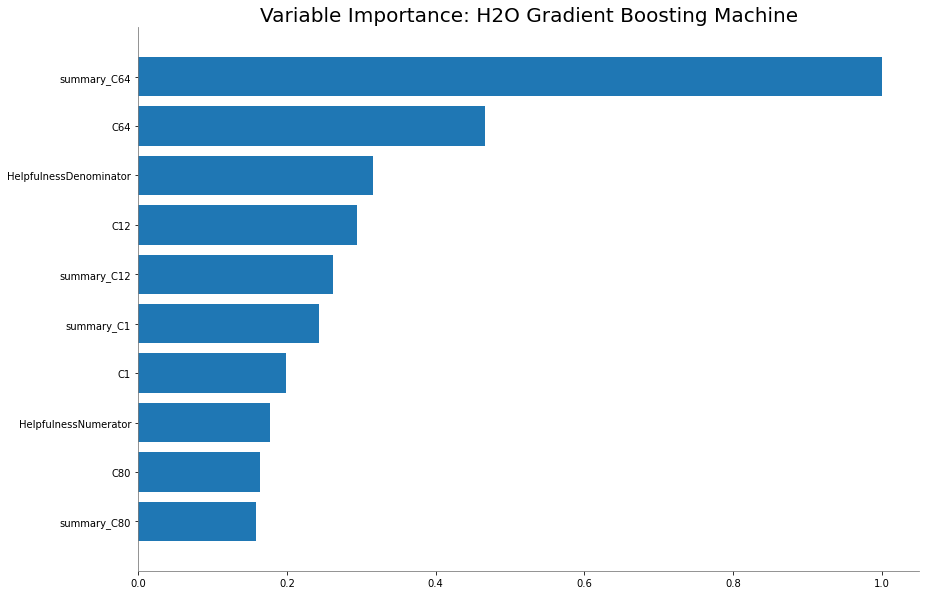

<Figure size 432x288 with 0 Axes>

In [50]:
gbm_plus_summary.varimp_plot()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


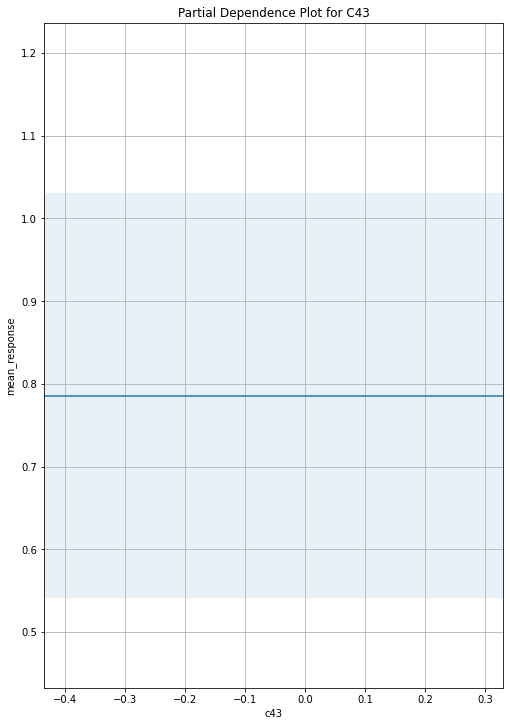

In [51]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data = ext_train, cols = ["C43"])

We can see that a low `C43` is associated with a smaller probability of positive review.  Let's see what words have a low `C43` value.

In [52]:
# Get Word Embeddings per Word
unique_words = words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]
word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]

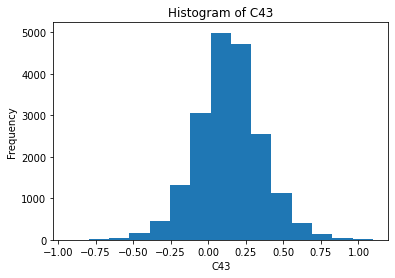

breaks,counts,mids_true,mids,widths
-0.997405,nan,nan,nan,nan
-0.862332,4,-0.566239,-0.929869,0.135073
-0.72726,14,-0.490149,-0.794796,0.135073
-0.592187,47,-0.42678,-0.659723,0.135073
-0.457114,174,-0.362447,-0.524651,0.135073
-0.322041,464,-0.296066,-0.389578,0.135073
-0.186969,1313,-0.228512,-0.254505,0.135073
-0.051896,3060,-0.16101,-0.119432,0.135073
0.0831768,4989,-0.09348,0.0156404,0.135073
0.218249,4725,-0.025942,0.150713,0.135073


In [53]:
word_embeddings["C43"].hist()

In [54]:
low_c43_words = word_embeddings[word_embeddings["C43"] < -1.1]
low_c43_words[["Word", "C43"]].head(15)

Word,C43
phosphate,-1.10225
sulfate,-1.13248


The words with low `C43` like `contacted`, `answered`, `emails`, `phone` and `refund` all seem to be related to contacting for a refund.  Words like: `salmonella` are obviously an indicator of a negative review for a food product.

## Predict on New Reviews

Now that we've built a model we are satisifed with, we will see how the model performs on new reviews.

* *"The taste is great! especially when you cook it with some vegetable and egg. I like it very much, though it's more expensive than the other noodles"*


* *"Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."*

In [55]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

In [56]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [58]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model, gbm_embeddings))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_embeddings))

Good Review: 
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.0861584,0.913842



None
Bad Review: 
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.81132,0.18868



None


In [59]:
h2o.cluster().shutdown()

H2O session _sid_bf92 closed.
